# Training a 2-D, Multivariate Convolutional Neural Network
### The Necessary Imports

In [1]:
# Initial imports
import numpy as np                                                              # for numpy tools
import pandas as pd                                                             # for DataFrame tools
from pathlib import Path                                                        # for writing paths to data files
from TBAC  import StockScrub                                                    # This line tells python to import the class  
import matplotlib.pyplot as plt                                      
%matplotlib inline
#import quandl
#import requests
import json
import os
#from GoogleNews import GoogleNews
import tensorflow as tf                                                    # for construcing and analyzing neural networks
import seaborn                                                                  # for customizing plot display settings
seaborn.set_style('darkgrid', {'legend.frameon':True})                          # chaning the settings of the plotting grid

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



### Reading in the Data Sets Used in Neural Networks

In [2]:
# variables used for initial neural network
stock_market_measures=['close','volume','VIX','beta']
optimizer_custom = tf.keras.optimizers.Adam(lr=0.001)

# creating StockScrub class object for Apple stock analysis
my_stock=StockScrub(["PFE"])                                                 
#aa=StockScrub(["AAL"])    
#amazon=StockScrub(["AMZN"])     
#bitcoin=StockScrub(["BTC"])     
#facebook=StockScrub(["FB"])    
#pfizer=StockScrub(["PFE"])  
#exxon=StockScrub(["XOM"])  
#zoom=StockScrub(["ZM"])  


### THIS SET OF DATA IS USED FOR THE 2D CONVOLUTIONAL NEURAL NETWORKS
# combines data from stored DataFrames to be processed for training
stock_df=my_stock.data_compile(start="2016-01-01")                         
#aa_df=aa.data_compile(start="2017-01-01")                                     
#amazon_df=amazon.data_compile(start="2017-01-01")                                      
#bitcoin_df=bitcoin.data_compile(start="2017-01-01")                                      
#facebook_df=facebook.data_compile(start="2019-01-01")                                       
#exxon_df=exxon.data_compile(start="2019-01-01")                                       
#zoom_df=zoom.data_compile(start="2019-01-01")        
stock_df.head()

,close,volume,VIX,beta,number of words,% positive,% negative,% uncertainty,% litigious,% modal-weak,% modal moderate,% modal strong,% constraining,average word length,vocabulary
2016-02-02,23.696730,48209098.0,23.15,0.472439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-03,23.563072,44972994.0,22.75,0.452962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-04,23.030977,56929892.0,23.05,0.411037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-05,23.054802,38931372.0,24.12,0.395585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-02-08,22.681542,47513120.0,25.40,0.406758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Defining window function used to split the data and some initial parameter values

In [3]:
# Our handy function for converting our dataset into the correct format

def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []                                                                       # initialize DataFrame for features
    y = []                                                                       # initialize DataFrame for target
    for i in range(len(df) - window - 1):                                        # generates list of indices from start until prior number of steps equal to the window
        features = df.iloc[i : (i + window), feature_col_number].values          # extracting vectors from DataFrame for features
        target = df.iloc[(i + window), target_col_number]                        # extracting observations from DataFrame for targets
        X.append(features)                                                       # appending extracted vectors to new DataFrame
        y.append(target)                                                         # appeding extracted observations to new DataFrame
    return np.array(X), np.array(y).astype(np.float64).reshape(-1, 1)            # converting DataFrames to numpy arrays

In [4]:
# Creating the features (X) and target (y) data using the window_data() function.

window_size = 3                                                                 # window size of 7 days (can adjust for different results)                                                                    # defining the column where you want to extract features
feature=0                                                                       # specifying the feature column
target_column = 0                                                               # defining the column where you want to extract targets
X, y = window_data(stock_df, window_size, feature, target_column)                     # splitting DataFrame into features and targets
X.shape                                                                         # gives shape of feature DataFrame

(1233, 3)

### Using Previously Defined Window Function on Remaining Features

In [5]:



# FOR DATA WITHOUT SENTIMENT SCORES
(volume_data, _) = window_data(stock_df, window_size, 1, 0)                           # reshaping volume data
(VIX_data, _) = window_data(stock_df, window_size, 2, 0)                              # reshaping VIX data
(beta_data, _) = window_data(stock_df, window_size, 3, 0)                             # reshaping beta data

# FOR DATA WITH SENTIMENT SCORES
(pos_data, _) = window_data(stock_df, window_size, 5, 0)                              # reshaping positive data
(neg_data, _) = window_data(stock_df, window_size, 6, 0)                              # reshaping negative data
(uncertain_data, _) = window_data(stock_df, window_size, 7, 0)                        # reshaping uncertainty data
(lit_data, _) = window_data(stock_df, window_size, 8, 0)                              # reshaping litigious data
(mw_data, _) = window_data(stock_df, window_size, 9, 0)                               # reshaping modal weak data
(mm_data, _) = window_data(stock_df, window_size, 10, 0)                              # reshaping modal moderate data
(ms_data, _) = window_data(stock_df, window_size, 11, 0)                              # reshaping modal strong data
(constrain_data, _) = window_data(stock_df, window_size, 12, 0)                       # reshaping constraining data










### Standardizing and Splitting the Data

In [6]:
from sklearn.preprocessing import StandardScaler                                # importing the StandardScaler
scaler = StandardScaler()                                                       # create an instance to scale the data

# standardizing features of data
X = scaler.fit_transform(X)                                                     # standardizing previous prices
volume_data = scaler.fit_transform(volume_data)                                 # standardizing volume data
VIX_data = scaler.fit_transform(VIX_data)                                       # standardizing VIX data
beta_data = scaler.fit_transform(beta_data)                                     # standardizing beta data

# standardizing sentiment features
pos_data = scaler.fit_transform(pos_data)                                       # standardizing pos data
neg_data = scaler.fit_transform(neg_data)                                       # standardizing neg data
uncertain_data = scaler.fit_transform(uncertain_data)                           # standardizing uncertain data
lit_data = scaler.fit_transform(lit_data)                                       # standardizing lit data
mw_data = scaler.fit_transform(mw_data)                                         # standardizing mw data
mm_data = scaler.fit_transform(mm_data)                                         # standardizing mm data
ms_data = scaler.fit_transform(ms_data)                                         # standardizing ms data
constrain_data = scaler.fit_transform(constrain_data)                           # standardizing constrain data



split = int(0.8 * len(X))                                                       # defining the splitting training and test sets 80/20 split 


# getting training sets from data
X_train = X[: split - 1]                                                         
VIX_data_train =  VIX_data[ : split - 1]                                        
volume_data_train =  volume_data[ : split - 1] 
beta_data_train =  beta_data[ : split - 1] 

pos_data_train =  pos_data[ : split - 1]    
neg_data_train =  neg_data[ : split - 1]    
uncertain_data_train =  uncertain_data[ : split - 1]    
lit_data_train =  lit_data[ : split - 1]    
mw_data_train =  mw_data[ : split - 1]    
mm_data_train =  mm_data[ : split - 1]    
ms_data_train =  ms_data[ : split - 1]    
constrain_data_train =  constrain_data[ : split - 1]      



# getting testing sets from data
X_test = X[split:]         
VIX_data_test = VIX_data[ split :]
volume_data_test = volume_data[ split :]
beta_data_test = beta_data[ split :]

pos_data_test =  pos_data[ split : ]
neg_data_test =  neg_data[ split : ]
uncertain_data_test =  uncertain_data[split : ]
lit_data_test =  lit_data[ split : ]
mw_data_test =  mw_data[split : ]
mm_data_test =  mm_data[split : ]
ms_data_test =  ms_data[split : ]
constrain_data_test =  constrain_data[split : ]


# splitting target data into testing and training sets
y_train = y[: split - 1]                                             
y_test = y[split:]
y_test.shape

(247, 1)

### Reshaping the Training and Testing Sets
#### now that we've split all the features into training and testing data, we combine these sets into one large training set and one large testing set

In [7]:
######################################.        RESHAPING THE DATA SETS.             ########################################################
###############
###################### TRAINING DATA
##############
# Reshaping training data: Dimension representations=(samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
volume_data_train = volume_data_train.reshape((volume_data_train.shape[0], volume_data_train.shape[1], 1))
VIX_data_train = VIX_data_train.reshape((VIX_data_train.shape[0], VIX_data_train.shape[1], 1))
beta_data_train = beta_data_train.reshape((beta_data_train.shape[0], beta_data_train.shape[1], 1))


#Training Data For Sentiment Features
pos_data_train = pos_data_train.reshape((pos_data_train.shape[0], pos_data_train.shape[1], 1))
neg_data_train = neg_data_train.reshape((neg_data_train.shape[0], neg_data_train.shape[1], 1))
uncertain_data_train = uncertain_data_train.reshape((uncertain_data_train.shape[0], uncertain_data_train.shape[1], 1))
lit_data_train = lit_data_train.reshape((lit_data_train.shape[0], lit_data_train.shape[1], 1))
mw_data_train = mw_data_train.reshape((mw_data_train.shape[0], mw_data_train.shape[1], 1))
mm_data_train = mm_data_train.reshape((mm_data_train.shape[0], mm_data_train.shape[1], 1))
ms_data_train = ms_data_train.reshape((ms_data_train.shape[0], ms_data_train.shape[1], 1))
constrain_data_train = constrain_data_train.reshape((constrain_data_train.shape[0], constrain_data_train.shape[1], 1))





################
###################### TESTING DATA
#############
# Reshaping testing data: Dimension representations=(samples, time steps, features)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
volume_data_test = volume_data_test.reshape((volume_data_test.shape[0], volume_data_test.shape[1], 1))
VIX_data_test = VIX_data_test.reshape((VIX_data_test.shape[0], VIX_data_test.shape[1], 1))
beta_data_test = beta_data_test.reshape((beta_data_test.shape[0], beta_data_test.shape[1], 1))



#Testing Data for Sentiment Features
pos_data_test = pos_data_test.reshape((pos_data_test.shape[0], pos_data_test.shape[1], 1))
neg_data_test = neg_data_test.reshape((neg_data_test.shape[0], neg_data_test.shape[1], 1))
uncertain_data_test = uncertain_data_test.reshape((uncertain_data_test.shape[0], uncertain_data_test.shape[1], 1))
lit_data_test = lit_data_test.reshape((lit_data_test.shape[0], lit_data_test.shape[1], 1))
mw_data_test = mw_data_test.reshape((mw_data_test.shape[0], mw_data_test.shape[1], 1))
mm_data_test = mm_data_test.reshape((mm_data_test.shape[0], mm_data_test.shape[1], 1))
ms_data_test = ms_data_test.reshape((ms_data_test.shape[0], ms_data_test.shape[1], 1))
constrain_data_test = constrain_data_test.reshape((constrain_data_test.shape[0], constrain_data_test.shape[1], 1))


#################################################    FOR THE PARTIAL MODEL.     #############################################################
# Train data used for Partial Model
data_train_partial = np.concatenate((X_train,volume_data_train,VIX_data_train,beta_data_train),
 axis=2)               # stacking training layers in third dimension



# Train data used for Partial Model
data_test_partial = np.concatenate((X_test,volume_data_test,VIX_data_test,beta_data_test), axis=2) 


#################################################    FOR THE FULL MODEL.     #############################################################
# Train data used for Full Model
data_train_full = np.concatenate((X_train,volume_data_train,VIX_data_train,beta_data_train,
                            pos_data_train,neg_data_train,uncertain_data_train,lit_data_train,
                            mw_data_train,mm_data_train,ms_data_train,constrain_data_train), axis=2)               # stacking training layers in third dimension



# Test data used for Full Model
data_test_full = np.concatenate((X_test,volume_data_test,VIX_data_test,beta_data_test,
                           pos_data_test,neg_data_test,uncertain_data_test,lit_data_test,
                           mw_data_test,mm_data_test,ms_data_test,constrain_data_test), axis=2)               # stacking testing layers in third dimension
X_train.shape                                                                                                 # checking shape of training data tensor

(985, 3, 1)

### RESHAPING DATA IN THE FOURTH DIMENSION
#### To train a 2D CNN, the data must be reshaped into 4 dimensions. The 4th dimension represents the axis along which the data is fed into the NN 
#### We will train a neural network first using Close,Volume,VIX,Beta
#### Lastly, training a neural network using previous mentioned features, as well as sentiment features

In [8]:
# DATA USING ONLY CLOSE,VOLUME,VIX,BETA
data_train_wide_partial = data_train_partial.reshape((X_train.shape[0], 
                                                      data_train_partial.shape[1], data_train_partial.shape[2], 1))  # reshaping training data into 4th dimension

data_test_wide_partial = data_test_partial.reshape((data_test_partial.shape[0],
                                                    data_test_partial.shape[1], data_test_partial.shape[2], 1))    # reshapiong test data into 4th dimension




# DATA USING ALL FEATURES
data_train_wide_full = data_train_full.reshape((X_train.shape[0],
                                                data_train_full.shape[1], data_train_full.shape[2], 1))  # reshaping training data into 4th dimension

data_test_wide_full = data_test_full.reshape((data_test_full.shape[0],
                                              data_test_full.shape[1], data_test_full.shape[2], 1))    # reshapiong test data into 4th dimension



data_train_wide_full.shape                                                                                  # confirms that we have 4-dimensional training data

(985, 3, 12, 1)

## DEFINING FUNCTION THAT CREATES 2D Convolutional NN Function; ORIGINAL FUNCTION PROVIDED BY MR. WALES

In [9]:
def basic_conv2D(n_filters=24, fsize=5, window_size=5, n_features=2):
    new_model = tf.keras.Sequential()
    # Hypothetically, we could also tune the padding and activation here.
    new_model.add(tf.keras.layers.Conv2D(4*n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
    #new_model.add(tf.keras.layers.Dropout(0.20))
    new_model.add(tf.keras.layers.MaxPooling2D((3, 3),padding='same'))
    # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(tf.keras.layers.Conv2D(5*n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
    #new_model.add(tf.keras.layers.MaxPooling2D((2, 2),padding='same'))
    #new_model.add(tf.keras.layers.Dropout(0.20))
    new_model.add(tf.keras.layers.Flatten())                                                              # flattening layer                                           
    new_model.add(tf.keras.layers.Dense(1500, activation='linear'))                                         # Dense layer for learning
    new_model.add(tf.keras.layers.Dense(500))                                                             # Denser layer for learning
    new_model.add(tf.keras.layers.Dense(100,activation='linear'))                                                             # Denser layer for learning
    new_model.add(tf.keras.layers.Dense(1))                                                               # single ouput layer 
    new_model.compile(optimizer="adam", loss="mean_squared_error")                                        # defining optimizer and loss function
    return new_model                                                                                      # returning the model

### DEFINING THE NEURAL NETWORK AND COMPILING THE MODEL

In [10]:
model = basic_conv2D(n_filters=40, fsize=3, window_size=window_size, n_features=data_train_wide_partial.shape[2]) # defining the parameters of the model
model.compile(optimizer="adam", loss="mean_squared_error")                                                # compiling the model
model.summary()                                                                                           # gives summary constructed model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 4, 160)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 2, 160)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2, 200)         96200     
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1500)              601500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               750500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5

In [11]:
# Fitting the model
hist=model.fit(data_train_wide_partial, y_train, epochs=30, shuffle=False, verbose=1,batch_size=40)           # begin training of NN, with training data and specified e

Epoch 1/30
25/25 [==============================] - 2s 20ms/step - loss: 318.9853
Epoch 2/30
25/25 [==============================] - 1s 26ms/step - loss: 448.7504
Epoch 3/30
25/25 [==============================] - 1s 25ms/step - loss: 83.0299
Epoch 4/30
25/25 [==============================] - 0s 17ms/step - loss: 434.9136
Epoch 5/30
25/25 [==============================] - 0s 19ms/step - loss: 452.1592
Epoch 6/30
25/25 [==============================] - 0s 18ms/step - loss: 88.2014
Epoch 7/30
25/25 [==============================] - 0s 18ms/step - loss: 43.3373
Epoch 8/30
25/25 [==============================] - 0s 17ms/step - loss: 61.3519
Epoch 9/30
25/25 [==============================] - 0s 19ms/step - loss: 17.6808
Epoch 10/30
25/25 [==============================] - 0s 17ms/step - loss: 53.1495
Epoch 11/30
25/25 [==============================] - 0s 18ms/step - loss: 28.9887
Epoch 12/30
25/25 [==============================] - 0s 18ms/step - loss: 4.6287
Epoch 13/30
25/25 [===

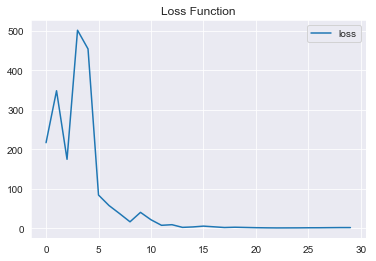

In [12]:
plt.plot(hist.history["loss"])
plt.title("Loss Function")
plt.legend(["loss"])
plt.show()
#predicted = model.predict(X_test)                                                                         # making predictions using test data
#predicted_prices = scaler.inverse_transform(predicted)                                                    # Recover the original prices instead of the scaled version

In [13]:
# Create a DataFrame of Real and Predicted values
predictions = model.predict(data_test_wide_partial)
conv_acc_df = pd.DataFrame()
conv_acc_df['Actual'] = y_test[:,0]
conv_acc_df['Predict'] = predictions[:,0]
conv_acc_df.head(10)

model.evaluate(data_test_wide_partial, y_test)                                                                            # evaluating performance of the model

8/8 [==============================] - 0s 5ms/step - loss: 11.1579


11.157930374145508

## Plotting Real and Predicted Values of Conv 2D NN

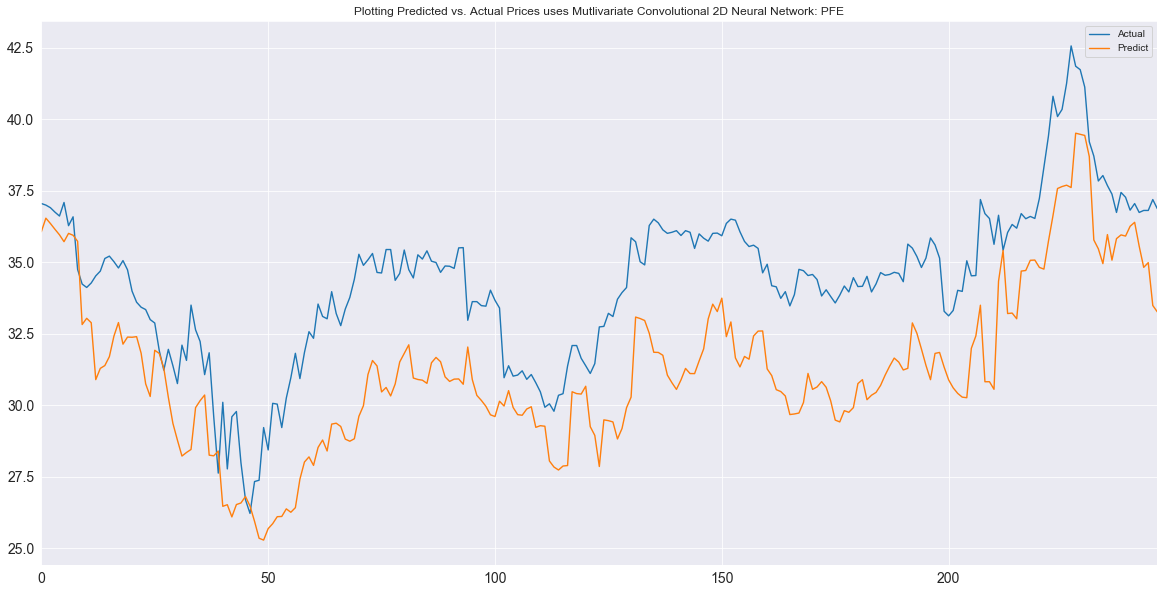

In [23]:
# Plot the real vs predicted prices as a line chart
#stocks.plot(title="Multivariate Multistep LSTM RNN")
conv_acc_df.plot(figsize=(20,10),title="Plotting Predicted vs. Actual Prices uses Mutlivariate Convolutional 2D Neural Network: PFE",fontsize=14,linewidth=1.4)

## Saving the Model for Future Use

In [108]:
#model.save('MV-MT-LSTM-RNN')

# Running the Full Model; Includes Sentiment Scores

In [15]:
def full_model_conv2D(n_filters=24, fsize=5, window_size=5, n_features=2):
    new_model = tf.keras.Sequential()
    # Hypothetically, we could also tune the padding and activation here.
    new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="tanh", input_shape=(window_size, n_features, 1)))
    #new_model.add(tf.keras.layers.Dropout(0.1))
    new_model.add(tf.keras.layers.MaxPooling2D((3, 3),padding='same'))
    # Flatten will take our convolution filters and lay them out end to end so our dense layer can predict based on the outcomes of each
    new_model.add(tf.keras.layers.Conv2D(4*n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
    #new_model.add(tf.keras.layers.MaxPooling2D((2, 2),padding='same'))
    new_model.add(tf.keras.layers.Dropout(0.1))
    new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features, 1)))
    new_model.add(tf.keras.layers.Dropout(0.1))
    new_model.add(tf.keras.layers.Flatten())                                                              # flattening layer                                           
    new_model.add(tf.keras.layers.Dense(1000, activation='relu'))                                         # Dense layer for learning
    new_model.add(tf.keras.layers.Dense(500))                                                             # Denser layer for learning
    new_model.add(tf.keras.layers.Dense(150,activation='relu'))                                                             # Denser layer for learning
    new_model.add(tf.keras.layers.Dense(1))                                                               # single ouput layer 
    new_model.compile(optimizer="adam", loss="mean_squared_error")                                        # defining optimizer and loss function
    return new_model                                                                                      # returning the model

## Defining Parameters for Full Model

In [16]:
model_full = full_model_conv2D(n_filters=40, fsize=3, window_size=window_size, n_features=data_train_wide_full.shape[2]) # defining the parameters of the model
model_full.compile(optimizer="adam", loss="mean_squared_error")                                                # compiling the model
model_full.summary()                                                                                           # gives summary constructed model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 12, 40)         160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 40)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 4, 160)         19360     
_________________________________________________________________
dropout (Dropout)            (None, 1, 4, 160)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 4, 40)          19240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 4, 40)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)              

### Fitting the Full Model

In [17]:
hist=model_full.fit(data_train_wide_full, y_train, epochs=30, shuffle=False, verbose=1,batch_size=40)     

Epoch 1/30
25/25 [==============================] - 1s 15ms/step - loss: 443.9917
Epoch 2/30
25/25 [==============================] - 0s 13ms/step - loss: 598.6825
Epoch 3/30
25/25 [==============================] - 0s 13ms/step - loss: 357.4764
Epoch 4/30
25/25 [==============================] - 0s 12ms/step - loss: 260.3772
Epoch 5/30
25/25 [==============================] - 0s 11ms/step - loss: 195.8059
Epoch 6/30
25/25 [==============================] - 0s 13ms/step - loss: 152.1141
Epoch 7/30
25/25 [==============================] - 0s 13ms/step - loss: 117.1091
Epoch 8/30
25/25 [==============================] - 0s 14ms/step - loss: 73.7462
Epoch 9/30
25/25 [==============================] - 0s 12ms/step - loss: 49.4230
Epoch 10/30
25/25 [==============================] - 0s 12ms/step - loss: 30.7272
Epoch 11/30
25/25 [==============================] - 0s 13ms/step - loss: 18.1887
Epoch 12/30
25/25 [==============================] - 0s 14ms/step - loss: 10.5871
Epoch 13/30
25/25 

## Plotting the Loss from full Model

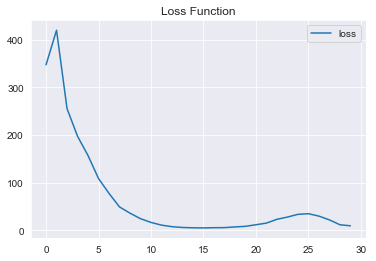

In [19]:
plt.plot(hist.history["loss"])
plt.title("Loss Function")
plt.legend(["loss"])
plt.show()

## Create DataFrame of Real and Predicted Values for the Model

In [20]:
# Create a DataFrame of Real and Predicted values
predictions = model_full.predict(data_test_wide_full)
conv_acc_df_full = pd.DataFrame()
conv_acc_df_full['Actual'] = y_test[:,0]
conv_acc_df_full['Predict'] = predictions[:,0]
conv_acc_df_full.head(10)

model_full.evaluate(data_test_wide_full, y_test)      

8/8 [==============================] - 0s 3ms/step - loss: 20.4273


20.427282333374023

## Plotting the Results of the Full Model (Additional Convolutional Layer, Droupout Layers, increased epochs and batch size)

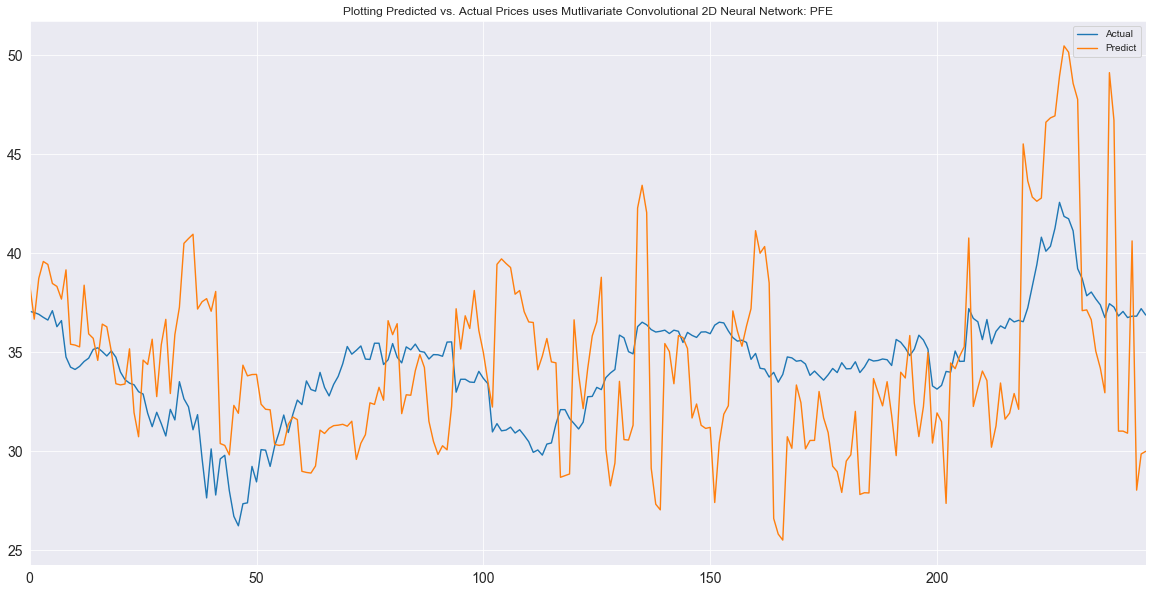

In [22]:
# Plot the real vs predicted prices as a line chart
#stocks.plot(title="Multivariate Multistep LSTM RNN")
conv_acc_df_full.plot(figsize=(20,10),title="Plotting Predicted vs. Actual Prices uses Mutlivariate Convolutional 2D Neural Network: PFE",fontsize=14,linewidth=1.4)